In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
#figure stuff
plt.rcParams['axes.grid']=True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titleweight']="bold"
plt.rcParams['mathtext.default']=u'regular'

In [36]:
# read in the files 

study_dates = pd.read_csv('nct2date.csv', parse_dates=['study_first_submitted'])
study_dates['year'] = study_dates['study_first_submitted'].apply(lambda x: x.year)
study_dates.head()

,nct_id,intervention_name,study_first_submitted,year
0,NCT02679326,Therapeutic ultrasound,2016-02-07,2016
1,NCT02676362,Gingival crevicular fluid collection with filt...,2016-02-01,2016
2,NCT02672930,Electrocardiogram (ECG),2016-01-17,2016
3,NCT02675283,Simtomax,2016-01-25,2016
4,NCT02677220,CI532 cochlear implant,2016-02-03,2016


In [37]:
# add information about disease
disease_df=pd.read_csv('conditions.txt',sep='|')
disease_df.head()

,id,nct_id,name,downcase_name
0,4306861,NCT04328025,HIV,hiv
1,4307524,NCT04323176,Hiv,hiv
2,4308169,NCT04318509,PKU,pku
3,4308872,NCT04313699,Aging,aging
4,4310806,NCT04299854,Obese,obese


In [38]:
df = pd.read_table('outcome_analyses.txt', sep='|', low_memory=False)
df = pd.merge(df, study_dates, on='nct_id')

df=pd.merge(df, disease_df[['nct_id','downcase_name']], on='nct_id')

#Get rid of p-values that are not percentages or between 0 and 1
df = df[~((df['p_value']>100) | (df['p_value']<0))].reset_index(drop=True)
is_percentage = df['p_value_description'].str.contains('denoted in percentage', case=False).fillna(False)
df['p_value'] = (df['p_value'] / 100.).where(is_percentage, other=df['p_value']) 
df = df[~((df['p_value']>1) | (df['p_value']<0))].reset_index(drop=True)
df = df[~df['p_value'].isnull()]

df.head()

,id,nct_id,outcome_id,non_inferiority_type,non_inferiority_description,param_type,param_value,dispersion_type,dispersion_value,p_value_modifier,...,p_value_description,method,method_description,estimate_description,groups_description,other_analysis_description,intervention_name,study_first_submitted,year,downcase_name
0,1157332,NCT04072432,2107907,Other,Analyses of variance for repeated measures (AN...,Mean Difference (Final Values),18.0,NaN,NaN,NaN,...,p values were corrected for multiple compariso...,ANOVA,ANOVA for repeated measures,NaN,NaN,NaN,Iron sucrose,2019-08-26,2019,"kidney failure, acute"
1,1157345,NCT04012970,2108007,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANOVA,"2-way, repeated measures",NaN,NaN,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain
2,1157346,NCT04012970,2108008,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANOVA,"2-way, repeated measures",NaN,NaN,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain
3,1157347,NCT04012970,2108009,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANCOVA,NaN,NaN,Tone change ran with covariates (baseline stif...,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain
4,1157348,NCT04012970,2108009,Superiority,NaN,NaN,NaN,NaN,NaN,<,...,NaN,ANOVA,"2-way, repeated measures",NaN,NaN,NaN,Manual spinal mobilisations,2019-07-03,2019,lower back pain


In [39]:
#ok, now, write df to a dataframe so that when I make plot notebooks it is simple
df.to_csv('working_df.tsv',sep='\t')

# Asset 1: diseases relevant to clinical trials through time 
- Here I the diseases relevant to clinical trials have changed over time

In [40]:
len(df.groupby('downcase_name')['nct_id'].count().sort_values(ascending=False))

1842

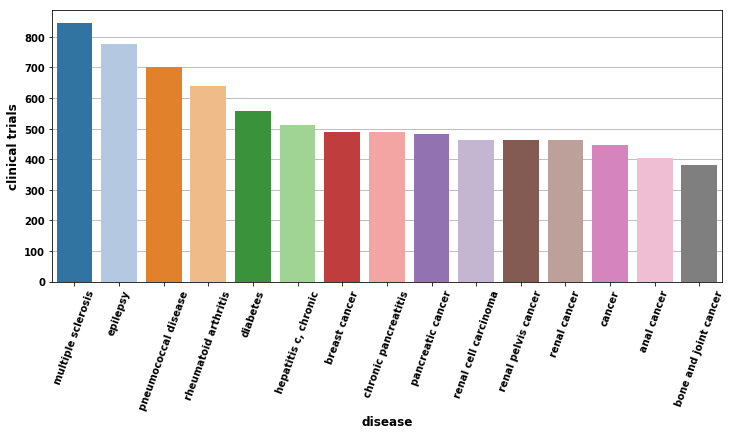

In [41]:
#let's see what the most studies disease are
plt.figure(figsize=(12,5))
t=pd.DataFrame(df.groupby('downcase_name')['nct_id'].count().sort_values(ascending=False))
sns.barplot(x=t.index[0:15],y=t['nct_id'][0:15], data=t[0:15],palette='tab20')
plt.xticks(rotation=70)
plt.ylabel('clinical trials',size=12)
plt.xlabel('disease',size=12)

disease_order=t.index[0:14]

Text(0, 0.5, 'fraction of clinical trials')

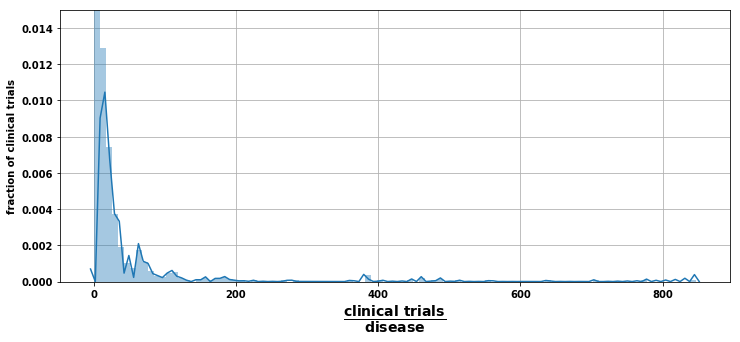

In [42]:
# now let's plot the total distribution of clinical trials
plt.figure(figsize=(12,5))
sns.distplot(t['nct_id'], bins=100)
plt.ylim(0,0.015)
plt.xlabel(r'$\frac{clinical\ trials}{disease}$',size=20)
plt.ylabel('fraction of clinical trials')

In [43]:
# now I want to know plot how the clinical trials for the most popular disease are distributed accross time
POPULAR_CUTOFF = 15

downcase_name_by_popularity = df.groupby('downcase_name')['nct_id'].nunique().sort_values(ascending=False).index.tolist()
popular_downcase_name = downcase_name_by_popularity[:POPULAR_CUTOFF]

m = df.groupby(['downcase_name','year'])['nct_id'].nunique().unstack().fillna(0)
row_normalized_m = m.sub(m.mean(axis=1), axis=0).div(m.std(axis=1), axis=0)
col_normalized_m = m.T.sub(m.T.mean(axis=1), axis=0).div(m.T.std(axis=1), axis=0).T

Text(0.5, 0.98, 'col z-score')

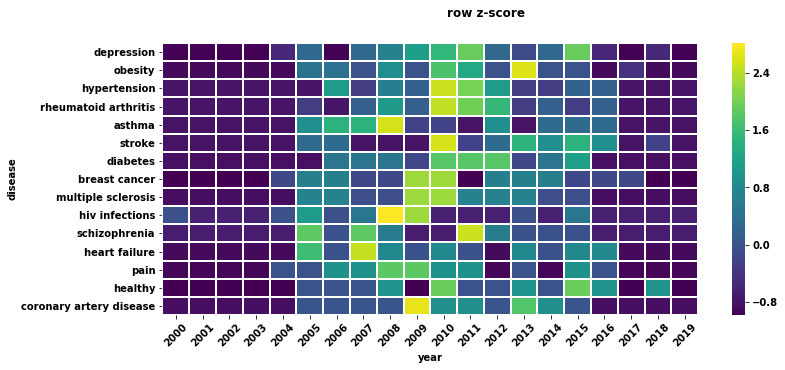

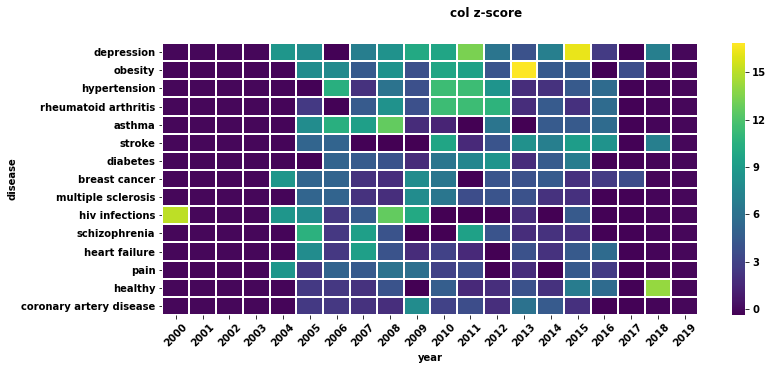

In [44]:
#plt.figure(figsize=(12,5))
#sns.heatmap(m.loc[popular_downcase_name], linewidths=1, cmap='viridis',  xticklabels=True, yticklabels=True)
#plt.xticks(rotation=45)

plt.figure(figsize=(12,5))
sns.heatmap(row_normalized_m.loc[popular_downcase_name], linewidths=1, cmap='viridis',  xticklabels=True, yticklabels=True)
plt.xticks(rotation=45)
plt.ylabel('disease')
plt.suptitle('row z-score', weight='bold')

plt.figure(figsize=(12,5))
sns.heatmap(col_normalized_m.loc[popular_downcase_name], linewidths=1, cmap='viridis',  xticklabels=True, yticklabels=True)
plt.xticks(rotation=45)
plt.ylabel('disease')
plt.suptitle('col z-score', weight='bold')

In [45]:
subset = row_normalized_m.loc[downcase_name_by_popularity[:15]].diff(axis=1).fillna(0)

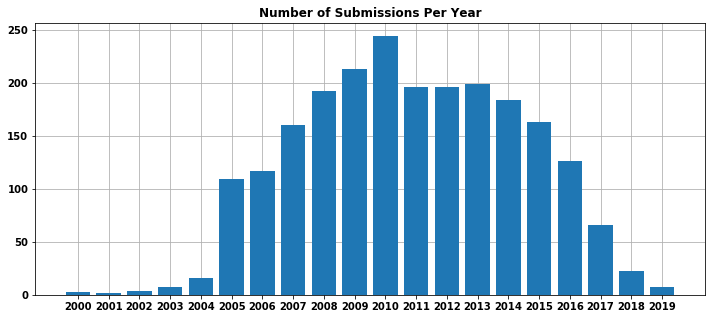

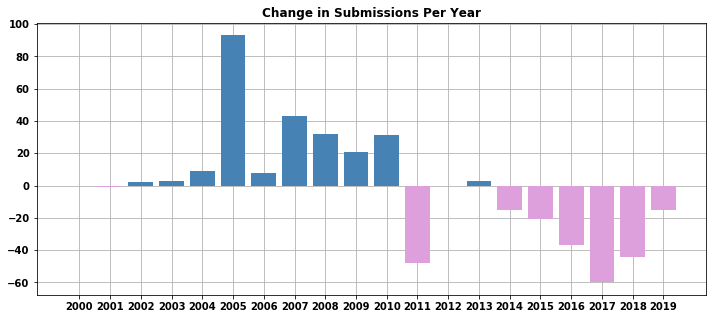

In [46]:
plt.figure(figsize=(12,5))
submissions_per_year = df.groupby('year')['nct_id'].nunique().reset_index()
plt.bar(submissions_per_year['year'], submissions_per_year['nct_id'])
plt.title('Number of Submissions Per Year')
_ = plt.xticks(subset.columns)


plt.figure(figsize=(12,5))
submission_change = submissions_per_year.set_index('year').nct_id.diff().fillna(0)

positive = submission_change[submission_change>0].reset_index()
nonpositive = submission_change[submission_change<=0].reset_index()

plt.bar(positive['year'], positive['nct_id'], color='steelblue')
plt.bar(nonpositive['year'], nonpositive['nct_id'], color='plum')

plt.title('Change in Submissions Per Year')
_ = plt.xticks(subset.columns)